In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('./data/train.txt', header=None)
test = pd.read_csv('./data/apply_new.txt', header=None)

In [4]:
train.columns = ['pid', 'label', 'gender', 'age', 'tagid', 'time', 'province', 'city', 'model', 'make']
test.columns = ['pid', 'gender', 'age', 'tagid', 'time', 'province', 'city', 'model', 'make']

data = pd.concat([train, test], axis=0)

### 1、数据探索

In [5]:
train.head()

,pid,label,gender,age,tagid,time,province,city,model,make
0,1016588,0,NaN,NaN,"[4457057,9952871,8942704,11273992,12410356,129...","[1.606747390128E12,1.606747390128E12,1.6067473...",广西,北海,华为,华为 mate20pro
1,1295808,1,NaN,5.0,"[10577375,13567578,4437795,8934804,9352464,133...","[1.605842042532E12,1.592187596698E12,1.5598650...",广东,广州,OPPO,r11
2,1110160,0,NaN,NaN,"[11171956,9454883,9361934,10578048,10234462,12...","[1.607351673175E12,1.607351673175E12,1.6073516...",内蒙古,锡林郭勒盟,小米,小米 红米note2
3,1132597,0,NaN,2.0,"[4457927,9412324,12292192,9231799,11977927,852...","[1.56015519913E12,1.56015519913E12,1.582942163...",四川,成都,vivo,vivo x20
4,1108714,0,NaN,NaN,"[5737867,5105608,13792904,5454488,13098817,141...","[1.591494981671E12,1.616071068225E12,1.6160710...",湖南,长沙,vivo,x23


In [6]:
train.shape

(300000, 10)

In [7]:
test.shape

(100000, 9)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   pid       300000 non-null  int64  
 1   label     300000 non-null  int64  
 2   gender    57638 non-null   float64
 3   age       261369 non-null  float64
 4   tagid     300000 non-null  object 
 5   time      300000 non-null  object 
 6   province  300000 non-null  object 
 7   city      300000 non-null  object 
 8   model     300000 non-null  object 
 9   make      300000 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 22.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   pid       100000 non-null  int64  
 1   gender    16224 non-null   float64
 2   age       87129 non-null   float64
 3   tagid     100000 non-null  object 
 4   time      100000 non-null  object 
 5   province  100000 non-null  object 
 6   city      100000 non-null  object 
 7   model     100000 non-null  object 
 8   make      100000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 6.9+ MB


In [10]:
for col in [x for x in data.columns if x not in ['label']]:
    data[col] = data[col].fillna('-1')
    data[col] = data[col].astype('str')

In [11]:
data.head()

,pid,label,gender,age,tagid,time,province,city,model,make
0,1016588,0.0,-1,-1,"[4457057,9952871,8942704,11273992,12410356,129...","[1.606747390128E12,1.606747390128E12,1.6067473...",广西,北海,华为,华为 mate20pro
1,1295808,1.0,-1,5.0,"[10577375,13567578,4437795,8934804,9352464,133...","[1.605842042532E12,1.592187596698E12,1.5598650...",广东,广州,OPPO,r11
2,1110160,0.0,-1,-1,"[11171956,9454883,9361934,10578048,10234462,12...","[1.607351673175E12,1.607351673175E12,1.6073516...",内蒙古,锡林郭勒盟,小米,小米 红米note2
3,1132597,0.0,-1,2.0,"[4457927,9412324,12292192,9231799,11977927,852...","[1.56015519913E12,1.56015519913E12,1.582942163...",四川,成都,vivo,vivo x20
4,1108714,0.0,-1,-1,"[5737867,5105608,13792904,5454488,13098817,141...","[1.591494981671E12,1.616071068225E12,1.6160710...",湖南,长沙,vivo,x23


In [12]:
train.label.mean()

0.5

In [13]:
data[data.label.notna()].gender.value_counts()

-1     242362
0.0     34323
1.0     23315
Name: gender, dtype: int64

In [14]:
data[data.label.notna()].age.value_counts().sort_index()

-1     38631
1.0    41278
2.0    32632
3.0    66861
4.0    61678
5.0    39936
6.0    18984
Name: age, dtype: int64

In [15]:
len(train.province.unique())

34

In [16]:
len(test.province.unique())

34

In [17]:
len(train.city.unique())

315

In [18]:
len(test.city.unique())

310

In [19]:
len(train.model.unique())

119

In [20]:
len(test.model.unique())

73

In [21]:
set(test.model.unique()) - set(train.model.unique())

{'8848钛金手机',
 'E人E本',
 'Utoutu',
 '世纪星',
 '东芝',
 '云创通',
 '台电',
 '斐讯',
 '爱我',
 '瑞芯',
 '黑鲨'}

In [22]:
train.model.value_counts()

OPPO       127881
vivo        69619
华为          49819
荣耀          16672
小米           8630
            ...  
欧博信             1
极豆DVD导航         1
vetas           1
奥乐              1
卡布奇诺            1
Name: model, Length: 119, dtype: int64

In [23]:
len(train.make.unique())

1398

In [24]:
len(test.make.unique())

779

In [25]:
train.tagid.apply(lambda x: len(x.split(','))).max()

734

In [26]:
train.tagid.apply(lambda x: len(x.split(','))).min()

1

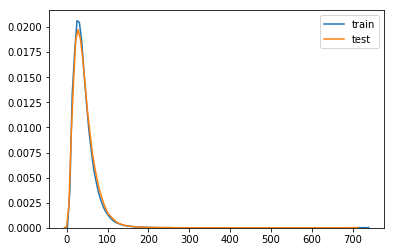

In [27]:
sns.kdeplot(train.tagid.apply(lambda x: len(x.split(','))), label='train')
sns.kdeplot(test.tagid.apply(lambda x: len(x.split(','))), label='test')

### 2、特征衍生

In [28]:
# 展开 tageid 和 time 信息
data['tagid'] = data['tagid'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
data['tagid'] = data['tagid'].apply(lambda x: x.split(','))

# 时间序列处理
data['time'] = data['time'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
data['time'] = data['time'].apply(lambda x: x.split(','))

In [29]:
pid = []
label = []
gender = []
age = []
tagid = []
time = []
province = []
city = []
model = []
make = []

In [30]:
for sub_data in data.values:
    s_tagid = sub_data[4]
    s_time = sub_data[5]
    for x, y in zip(s_tagid, s_time):
        pid.append(sub_data[0])
        label.append(sub_data[1])
        gender.append(sub_data[2])
        age.append(sub_data[3])
        tagid.append(x)
        time.append(y)
        province.append(sub_data[6])
        city.append(sub_data[7])
        model.append(sub_data[8])
        make.append(sub_data[9])

In [31]:
new_data = pd.DataFrame()
new_data['pid'] = pid
new_data['label'] = label
new_data['gender'] = gender
new_data['age'] = age
new_data['tagid'] = tagid
new_data['time'] = time
new_data['province'] = province
new_data['city'] = city
new_data['model'] = model
new_data['make'] = make

In [32]:
new_data['label'] = new_data['label'].fillna(-1)

new_data['time'] = new_data['time'].astype(float)
new_data['time'] = new_data['time'].astype('int64')

new_data['date'] = pd.to_datetime(new_data['time'], unit='ms')

In [33]:
new_data = new_data.sort_values(['pid', 'time'])

new_data_max_time = new_data.groupby(['pid'])['time'].max().reset_index()
new_data_max_time.columns = ['pid','max_time']
new_data = pd.merge(new_data,new_data_max_time,on=['pid'],how='left')
new_data['long'] = new_data['max_time'] - new_data['time']

In [34]:
# 计算用户的兴趣变化次数 统计用户兴趣出现几次变化
user_tagid_change = new_data.groupby(['pid'])['time'].nunique().reset_index()
user_tagid_change.rename(columns={'time': 'pid_tagid_change_time'}, inplace=True)
data = pd.merge(data, user_tagid_change, on=['pid'], how='left')

In [35]:
agg_list = {
    'time': ['mean', 'max', 'min', 'var', 'median','count'],
}

pid_time_feature = new_data.groupby(['pid']).agg(
    agg_list
)

In [36]:
pid_time_feature.columns = [x[0] + '_' + x[1] for x in pid_time_feature.columns]
pid_time_feature = pid_time_feature.reset_index()
data = pd.merge(data, pid_time_feature, on=['pid'], how='left')

In [37]:
new_data_feature = [
    'pid_tagid_change_time',
    'time_mean', 'time_max', 'time_min', 'time_var', 'time_median','time_count',
]

In [38]:
# 特征处理，对于 'province', 'city', 'model','make' 选择交集内的特征，其余特征置为 -1
for col in ['province', 'city', 'model','make']:
    in_set = set(train[col].unique()) & set(test[col].unique())
    data.loc[data[col].isin(list(in_set)),col] = data[col]
    data.loc[~data[col].isin(list(in_set)),col] = -1

In [39]:
# 二阶统计特征
us_feature = []
# count 编码 ，和lablending编码一个意思，一种编码方式
for col in ['gender', 'age', 'province', 'city', 'model','make']:
    data['{}_count'.format(col)] = data.groupby(col)[col].transform('count')
    data['{}_category'.format(col)] = data[col].astype('category')
    data['{}_category'.format(col)] = data['{}_category'.format(col)].cat.codes
    us_feature.append('{}_count'.format(col))
    us_feature.append('{}_category'.format(col))

In [40]:
corss_feature = ['gender', 'age', 'province', 'city', 'model','make']
# 交叉组合统计，就是组合特征的共现频次
while len(corss_feature) != 0:
    f = corss_feature.pop()
    for col in corss_feature:
        data['{}_{}_count'.format(f, col)] = data.groupby([f, col])[col].transform('count')
        data['{}_{}_category'.format(f, col)] = data[f].astype(str) + '_' + data[col].astype(str)
        data['{}_{}_category'.format(f, col)] = data['{}_{}_category'.format(f, col)].astype('category')
        data['{}_{}_category'.format(f, col)] = data['{}_{}_category'.format(f, col)].cat.codes
        us_feature.append('{}_{}_count'.format(f, col))
        us_feature.append('{}_{}_category'.format(f, col))

In [41]:
# 数据的特点是 训练集 的 label 是 五五开！
data['tagid'] = data['tagid'].apply(lambda x: ' '.join(x))

In [42]:
data.head()

,pid,label,gender,age,tagid,time,province,city,model,make,...,city_age_count,city_age_category,city_province_count,city_province_category,province_gender_count,province_gender_category,province_age_count,province_age_category,age_gender_count,age_gender_category
0,1016588,0.0,-1,-1,4457057 9952871 8942704 11273992 12410356 1293...,"[1.606747390128E12, 1.606747390128E12, 1.60674...",广西,北海,华为,华为 mate20pro,...,79,284,613,43,11683,39,1833,89,47757,0
1,1295808,1.0,-1,5.0,10577375 13567578 4437795 8934804 9352464 1332...,"[1.605842042532E12, 1.592187596698E12, 1.55986...",广东,广州,OPPO,r11,...,397,775,3906,113,21615,36,2711,87,40912,15
2,1110160,0.0,-1,-1,11171956 9454883 9361934 10578048 10234462 125...,"[1.607351673175E12, 1.607351673175E12, 1.60735...",内蒙古,锡林郭勒盟,小米,小米 红米note2,...,42,1945,349,282,7155,6,1209,14,47757,0
3,1132597,0.0,-1,2.0,4457927 9412324 12292192 9231799 11977927 8520...,"[1.56015519913E12, 1.56015519913E12, 1.5829421...",四川,成都,vivo,vivo x20,...,1155,870,8987,127,21566,18,3002,42,38206,6
4,1108714,0.0,-1,-1,5737867 5105608 13792904 5454488 13098817 1416...,"[1.591494981671E12, 1.616071068225E12, 1.61607...",湖南,长沙,vivo,x23,...,419,1973,3286,286,11794,66,1996,152,47757,0


In [43]:
def emb(df, f1, f2):
    emb_size = 16
    print('====================================== {} {} ======================================'.format(f1, f2))
    tmp = df.groupby(f1, as_index=False)[f2].agg({'{}_{}_list'.format(f1, f2): list})
    sentences = tmp['{}_{}_list'.format(f1, f2)].values.tolist()
    del tmp['{}_{}_list'.format(f1, f2)]
    for i in range(len(sentences)):
        sentences[i] = [str(x) for x in sentences[i]]
    model = Word2Vec(sentences, vector_size=emb_size, window=5, min_count=5, sg=0, hs=1, seed=2019)
    emb_matrix = []
    for seq in sentences:
        vec = []
        for w in seq:
            if w in model.wv:
                vec.append(model.wv.get_vector(w))
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        else:
            emb_matrix.append([0] * emb_size)
    emb_matrix = np.array(emb_matrix)
    feature = []
    for i in range(emb_size):
        tmp['{}_{}_emb_{}'.format(f1, f2, i)] = emb_matrix[:, i]
        feature.append('{}_{}_emb_{}'.format(f1, f2, i))
    del model, emb_matrix, sentences
    return tmp, feature

In [44]:
emb_cols = [
    ['pid', 'tagid'],
]
for f1, f2 in emb_cols:
    tmp, f = emb(new_data, f1, f2)
    data = data.merge(tmp, on=f1, how='left')
    us_feature.extend(f)

====================================== pid tagid ======================================


In [46]:
# 按照时间信息，抽取对应的tagid和time信息
new_tagid_list = new_data.groupby(['pid'])['tagid'].apply(list).reset_index()
new_tagid_list.columns = ['pid','new_tagid']

data = pd.merge(data, new_tagid_list, on=['pid'], how='left')

In [48]:
def get_list_info(x,i):
    if len(x) <= (-i):
        x = x + [-1] * (-i - len(x))
    return int(x[i])

for i in range(1,11):
    data['net_tagid_{}'.format(i)] = data['new_tagid'].apply(lambda x:get_list_info(x,-i))
    us_feature.append('net_tagid_{}'.format(i))

In [52]:
us_feature = us_feature + new_data_feature

target_list = ['age', 'province', 'city', 'model']

# 特征unique count特征
for index, col1 in enumerate(['age', 'province', 'city', 'model']):
    for col2 in ['age', 'province', 'city', 'model'][index:]:
        data['{}_in_{}_count'.format(col1, col2)] = data.groupby(col1)[col2].transform('count')
        data['{}_in_{}_nunique'.format(col1, col2)] = data.groupby(col1)[col2].transform('nunique')
        data['{}_in_{}_nunique/{}_in_{}_count'.format(col1, col2, col1, col2)] = data['{}_in_{}_nunique'.format(col1,
                                                                                                                col2)] / \
                                                                                 data['{}_in_{}_count'.format(col1,
                                                                                                              col2)]

        data['{}_in_{}_count'.format(col2, col1)] = data.groupby(col2)[col1].transform('count')
        data['{}_in_{}_nunique'.format(col2, col1)] = data.groupby(col2)[col1].transform('nunique')
        data['{}_in_{}_nunique/{}_in_{}_count'.format(col2, col1, col2, col1)] = data['{}_in_{}_nunique'.format(col2,
                                                                                                                col1)] / \
                                                                                 data['{}_in_{}_count'.format(col2,
                                                                                                              col1)]

        us_feature.append('{}_in_{}_count'.format(col1, col2))
        us_feature.append('{}_in_{}_nunique'.format(col1, col2))
        us_feature.append('{}_in_{}_nunique/{}_in_{}_count'.format(col1, col2, col1, col2))

        us_feature.append('{}_in_{}_count'.format(col2, col1))
        us_feature.append('{}_in_{}_nunique'.format(col2, col1))
        us_feature.append('{}_in_{}_nunique/{}_in_{}_count'.format(col2, col1, col2, col1))

train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [68]:
train_bert.shape

(300000, 4)

In [64]:
train_bert = train[['pid', 'tagid', 'new_tagid', 'label']].copy()
train_bert['new_tagid'] = train_bert.new_tagid.apply(lambda x: ' '.join(x))
test_bert = test[['pid', 'tagid', 'new_tagid']].copy()
test_bert['new_tagid'] = test_bert.new_tagid.apply(lambda x: ' '.join(x))

train_bert.to_csv('./data/train_bert.csv', index=False)
test_bert.to_csv('./data/test_bert.csv', index=False)

In [ ]:
# 使用bert训练模型
# 1.原始标签序列分类模型
# 2.按照日期排序后的标签分类模型
train_bert_pred = pd.read_csv('./data/roberta_pred_oof.csv')
test_bert_pred = pd.read_csv('./data/roberta_pred_test.csv')

train = pd.merge(train, train_bert_pred, on='pid')
test = pd.merge(test, test_bert_pred, on='pid')

In [54]:
# 引入kflod转化率
skf_ratdio = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_train_ratdio = np.zeros((train.shape[0], len(target_list)))
oof_test_ratdio = np.zeros((test.shape[0], len(target_list)))

for index, (train_index, valid_index) in enumerate(skf_ratdio.split(train, train['label'])):
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    X_test = test.copy()
    for k, col in enumerate(target_list):
        t = X_train.groupby(col)[['label']].mean().to_dict()
        X_valid['ratdio_{}'.format(col)] = X_valid[col].map(t['label'])
        oof_train_ratdio[valid_index, k] = X_valid['ratdio_{}'.format(col)].values
        X_test['ratdio_{}'.format(col)] = X_test[col].map(t['label'])
        oof_test_ratdio[:, k] = oof_test_ratdio[:, k] + X_test['ratdio_{}'.format(col)].values / skf_ratdio.n_splits

for i in range(0, len(target_list)):
    train[i] = oof_train_ratdio[:, i]
    test[i] = oof_test_ratdio[:, i]
    us_feature.append(i)

In [57]:
us_feature = list(set(us_feature))
us_feature.append('gender')
us_feature.append('age')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_train = np.zeros(shape=(train.shape[0]))
oof_test = np.zeros(shape=(test.shape[0]))

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': 0,
    'random_state': 42,
    'n_jobs': -1,
}
imp_Df = pd.DataFrame()
imp_Df['feature'] = us_feature

for index, (train_index, valid_index) in enumerate(skf.split(train, train['label'])):
    X_train, X_valid = train.iloc[train_index][us_feature].values, train.iloc[valid_index][us_feature].values
    y_train, y_valid = train.iloc[train_index]['label'], train.iloc[valid_index]['label']
    print(index)
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_valid, label=y_valid)
    lgb_model = lgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        valid_sets=[dval],
        early_stopping_rounds=50,
        verbose_eval=50,
    )
    X_valid_pred = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
    imp_Df[index] = lgb_model.feature_importance()

    oof_train[valid_index] = X_valid_pred
    oof_test = oof_test + lgb_model.predict(test[us_feature].values,
                                            num_iteration=lgb_model.best_iteration) / skf.n_splits

train['predict'] = oof_train
train['rank'] = train['predict'].rank()
train['p'] = 1
train.loc[train['rank'] <= train.shape[0] * 0.5, 'p'] = 0
# train['pre'] = train['predict'].apply(lambda x:1 if x>0.5 else 0)

bst_f1_tmp = f1_score(train['label'].values, train['p'].values)
print(bst_f1_tmp)
# bst_f1_tmp = f1_score(train['label'].values, train['pre'].values)
# print(bst_f1_tmp)
# bst_f1 = 0
# bst_thr = 0
# for thr in range(0,11):
#     thr = thr / 10
#     tmp = np.where(oof_train > thr,1,0)
#     bst_f1_tmp = f1_score(train['label'].values,tmp)
#     if bst_f1 < bst_f1_tmp:
#         bst_f1 = bst_f1_tmp
#         bst_thr = thr

# print(bst_f1,bst_thr)
#
submit = test[['pid']]
submit['tmp'] = oof_test
submit.columns = ['user_id', 'tmp']

submit['rank'] = submit['tmp'].rank()
submit['category_id'] = 1
submit.loc[submit['rank'] <= int(submit.shape[0] * 0.5), 'category_id'] = 0
# submit['pre'] = submit['tmp'].apply(lambda x:1 if x>0.5 else 0)

print(submit['category_id'].mean())

submit[['user_id', 'category_id']].to_csv('open_{}.csv'.format(str(bst_f1_tmp).split('.')[1]), index=False)
# print(submit['pre'].mean())

0
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.785909
[100]	valid_0's auc: 0.796961
[150]	valid_0's auc: 0.800093
[200]	valid_0's auc: 0.801108
[250]	valid_0's auc: 0.801849
[300]	valid_0's auc: 0.802506
[350]	valid_0's auc: 0.802871
[400]	valid_0's auc: 0.803353
[450]	valid_0's auc: 0.803743
[500]	valid_0's auc: 0.804019
[550]	valid_0's auc: 0.804085
[600]	valid_0's auc: 0.804051
Early stopping, best iteration is:
[564]	valid_0's auc: 0.80417
1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.784141
[100]	valid_0's auc: 0.796373
[150]	valid_0's auc: 0.798939
[200]	valid_0's auc: 0.799731
[250]	valid_0's auc: 0.8002
[300]	valid_0's auc: 0.800827
[350]	valid_0's auc: 0.801253
[400]	valid_0's auc: 0.801495
[450]	valid_0's auc: 0.801658
Early stopping, best iteration is:
[432]	valid_0's auc: 0.801766
2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.786823
[100]	valid_0's auc: 0.7971